In [1]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten,Conv2D, Conv2DTranspose, Concatenate,LeakyReLU, Dropout, Embedding,BatchNormalization, Activation
# from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import Adam, RMSprop, SGD
from matplotlib import pyplot
import numpy as np
from math import sqrt

Loading Datasets

In [2]:
# We are only loading the features of train data as we do not require the labels.
# Then we are dividing each pixel value by 127.5 and subtracting it from 1 to have pixel values in the range of -1 to 1.
# Finally, the X_train shape is (60000, 28, 28, 1).
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


function to generate latent points of the shape n_samplesxlatent_dim(100 in our case).

In [3]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

function to generate n real samples with 1 as a label, i.e. real image.

In [4]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

function to generate n fake samples using the generator with 0 as a label, i.e. fake image.

In [5]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y

function summarize the performance. This includes generating a fake sample, plotting it, and finally saving the model.

In [6]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.keras' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

function to plot the results. We’ll use this to plot the generated images by the  Generator in later stages.

In [7]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

Model Building

In [8]:
'''We are using couple of Dense, Flatten and Dropout layers with leaky relu as an activation function in hidden layers
  and sigmoid in the final layer, adam as an optimizer and binary cross-entropy as a loss function as the discriminator’s task
  is to perform the binary classification.'''
def define_discriminator(input_shape=(28, 28, 1)):
    # Initialize the weights
    weight_init = RandomNormal(stddev=0.02)

    # Define the input layer
    input_image = Input(shape=input_shape)

    # Flatten the input image
    features = Flatten()(input_image)

    # Define discriminator architecture with Dense layers, LeakyReLU activation, and Dropout
    features = Dense(1024, kernel_initializer=weight_init)(features)
    features = LeakyReLU(alpha=0.2)(features)
    features = Dropout(0.3)(features)

    features = Dense(512, kernel_initializer=weight_init)(features)
    features = LeakyReLU(alpha=0.2)(features)
    features = Dropout(0.3)(features)

    features = Dense(256, kernel_initializer=weight_init)(features)
    features = LeakyReLU(alpha=0.2)(features)
    features = Dropout(0.3)(features)

    # Output layer with sigmoid activation for binary classification
    output = Dense(1, activation='sigmoid')(features)

    # Create the discriminator model
    discriminator = Model(input_image, output)

    # Compile the model with Adam optimizer and binary cross-entropy loss
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return discriminator

In [9]:
'''We are using a couple of Dense layers to define the generator model with again leaky relu as an activation function
    in hidden layers and tanh in the final layer. The generated images G(z) will be of the shape 28x28x1.'''
def define_generator(latent_dim):
    # Initialize the weights
    weight_init = RandomNormal(stddev=0.02)

    # Define input layer for the latent space
    input_latent = Input(shape=(latent_dim,))

    # Generator architecture with Dense layers, LeakyReLU activation
    gen = Dense(256, kernel_initializer=weight_init)(input_latent)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Dense(512, kernel_initializer=weight_init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Dense(1024, kernel_initializer=weight_init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Output layer with tanh activation for image generation
    gen = Dense(28 * 28 * 1, kernel_initializer=weight_init)(gen)
    output_layer = Activation('tanh')(gen)

    # Reshape the output to the desired image shape
    output_layer = Reshape((28, 28, 1))(output_layer)

    # Create the generator model
    generator_model = Model(input_latent, output_layer)

    return generator_model

In [10]:
def define_gan(generator_model, discriminator_model):
    # Set the discriminator to not be trainable during GAN training
    discriminator_model.trainable = False

    # Connect the generator to the discriminator
    gan_output = discriminator_model(generator_model.output)

    # Create the GAN model
    gan_model = Model(generator_model.input, gan_output)

    # Compile the GAN model with Adam optimizer and binary cross-entropy loss
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    gan_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return gan_model


In [11]:
discriminator = define_discriminator()
generator = define_generator(100)
gan = define_gan(generator, discriminator)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


4/4 [==============================] - 0s 3ms/step
Epoch 1/1000, D Loss: 0.6964888572692871, G Loss: 0.6912531852722168
4/4 [==============================] - 0s 3ms/step
>Saved: model_0001.keras
4/4 [==============================] - 0s 3ms/step
Epoch 2/1000, D Loss: 0.5456553995609283, G Loss: 0.6890896558761597
4/4 [==============================] - 0s 3ms/step
>Saved: model_0002.keras
4/4 [==============================] - 0s 3ms/step
Epoch 3/1000, D Loss: 0.4609559178352356, G Loss: 0.6853249073028564
4/4 [==============================] - 0s 3ms/step
>Saved: model_0003.keras
4/4 [==============================] - 0s 3ms/step
Epoch 4/1000, D Loss: 0.4055759757757187, G Loss: 0.6785444021224976
4/4 [==============================] - 0s 3ms/step
>Saved: model_0004.keras
4/4 [==============================] - 0s 3ms/step
Epoch 5/1000, D Loss: 0.3853038474917412, G Loss: 0.6679720878601074
4/4 [==============================] - 0s 3ms/step
>Saved: model_0005.keras
4/4 [===============

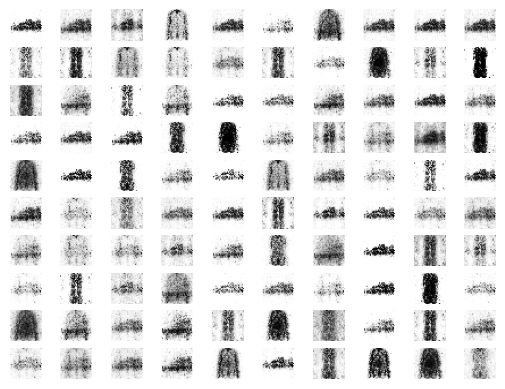

In [12]:
def train_gan(generator, discriminator, gan, X_train, latent_dim, n_epochs, batch_size):
    for epoch in range(n_epochs):
            # Train the discriminator
            X_real, y_real = generate_real_samples(X_train, batch_size)
            d_loss_real = discriminator.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, batch_size)
            d_loss_fake = discriminator.train_on_batch(X_fake, y_fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator
            z_input = generate_latent_points(latent_dim, batch_size)
            y_gan = ones((batch_size, 1))
            g_loss = gan.train_on_batch(z_input, y_gan)

            # Print progress
            print(f"Epoch {epoch + 1}/{n_epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss[0]}")

            # Save generated images and models at specific intervals
            summarize_performance(epoch, generator, latent_dim)

# Define training parameters
n_epochs = 1000
batch_size = 128

# Train the GAN
train_gan(generator, discriminator, gan, X_train, 100, n_epochs, batch_size)
